# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
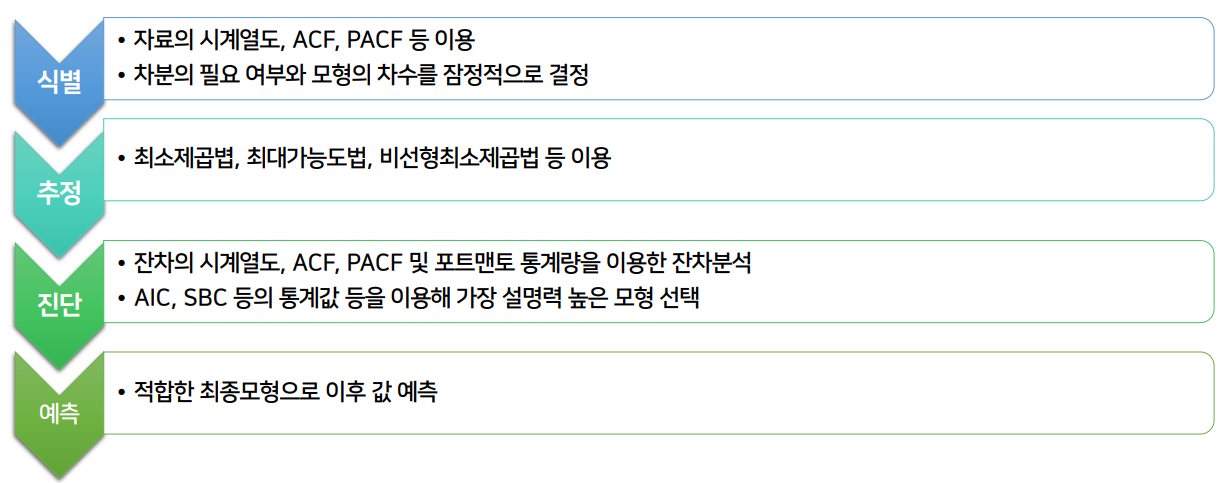

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [77]:
import os

import pandas as pd
#import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import yfinance as yf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [78]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [46]:
samsung_df.info()

# 결측치 없음

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


* 결측치 없음

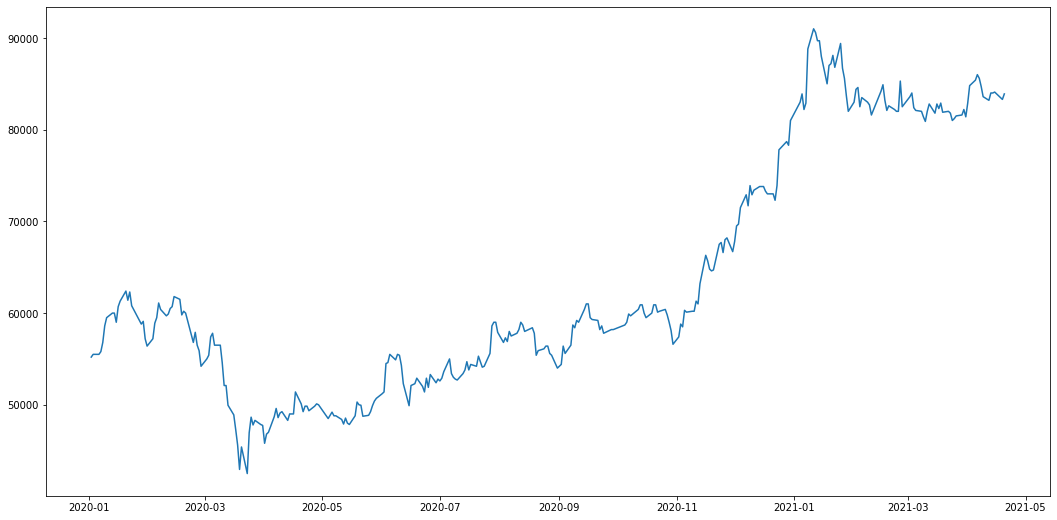

In [5]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Stock Price')
plt.show()

* 불규칙적이나 평균이 일정하지 않은 모습
* 하락하는 구간이 있으나 전반적으로 시간이 흐를수록 증가하는 추세
* 비정상 시계열로 판단

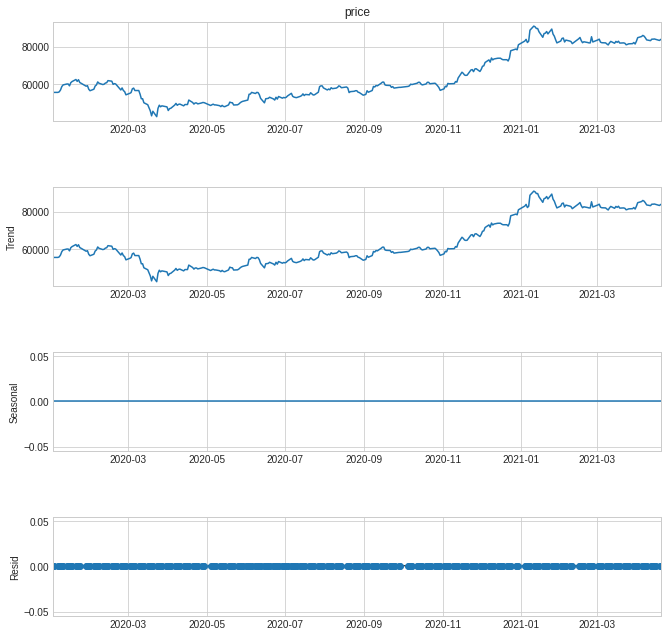

In [58]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(samsung_df['price'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

* 분해로 추세 없애지 못함

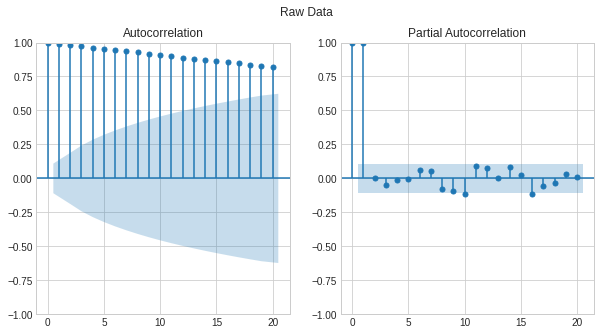

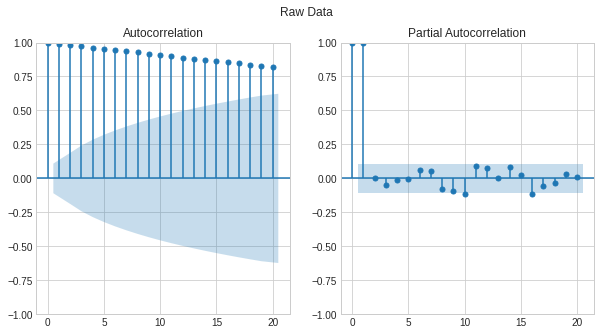

In [47]:
# 정상성(Stationarity) 검정 - ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(samsung_df['price'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(samsung_df['price'].values.squeeze(), lags=20, ax=ax[1])

* ACF이 감소하는 추세 -> 비정상 시계열
* 차분(Differencing) 과정 필요

In [79]:
# 차분 (Differencing)

diff_samsung_df = samsung_df.copy()
diff_samsung_df = diff_samsung_df['price'].diff() # 차분
diff_samsung_df = diff_samsung_df.dropna() # 차분 후 생기는 결측치 제거
print(f"{'-'*15}Raw data{'-'*15}")
print(samsung_df['price'].head())
print(f"{'-'*15}Differenced data{'-'*15}")
print(diff_samsung_df.head())

---------------Raw data---------------
day
2020-01-02    55200.0
2020-01-03    55500.0
2020-01-06    55500.0
2020-01-07    55800.0
2020-01-08    56800.0
Name: price, dtype: float64
---------------Differenced data---------------
day
2020-01-03     300.0
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
Name: price, dtype: float64


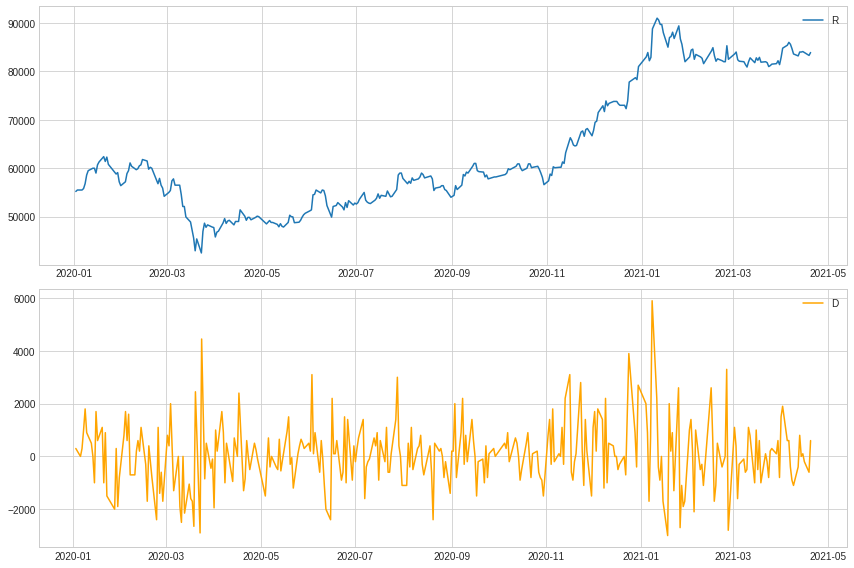

In [60]:
# 차분(Differencing) 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(samsung_df['price'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_samsung_df, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

* 노란색 그래프 : 정상 시계열의 모습 확인

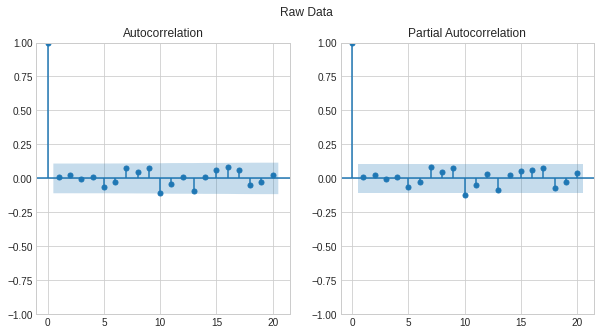

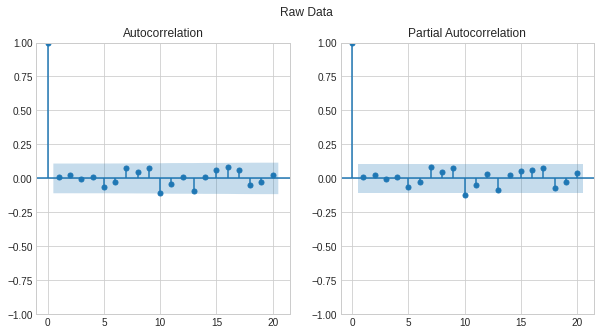

In [61]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_samsung_df.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_samsung_df.values.squeeze(), lags=20, ax=ax[1])

* ACF가 구간 안에 들어옴

In [80]:
# 차분 이전 데이터셋을 훈련셋, 테스트셋으로 8:2로 split

train_data = samsung_df[:len(samsung_df)-65]
test_data = samsung_df[len(samsung_df)-65:]

In [81]:
# 최적 파라미터 탐색

p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(train_data['price'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA pdq : (0, 1, 0) >> AIC : 4365.03
ARIMA pdq : (0, 1, 1) >> AIC : 4366.44
ARIMA pdq : (0, 2, 0) >> AIC : 4507.08
ARIMA pdq : (0, 2, 1) >> AIC : 4477.9
ARIMA pdq : (1, 1, 0) >> AIC : 4366.41
ARIMA pdq : (1, 1, 1) >> AIC : 4365.97
ARIMA pdq : (1, 2, 0) >> AIC : 4489.37
ARIMA pdq : (1, 2, 1) >> AIC : 4454.09


* AIC가 가장 적어지는 파라미터 선택 : (0, 1, 0)

In [82]:
# 최적 파라미터 선택
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 0), 4365.03)]


<h2>ARIMA 모델 적용

In [76]:
model = ARIMA(train_data['price'].values, order=(0, 1, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  257
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2181.513
Date:                Tue, 29 Aug 2023   AIC                           4365.027
Time:                        18:27:08   BIC                           4368.572
Sample:                             0   HQIC                          4366.452
                                - 257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.471e+06   8.64e+04     17.024      0.000     1.3e+06    1.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                73.91
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.68
Prob(H) (two-sided):                  0.99   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
index = test_data.drop('price', axis=1)

""
day
2021-01-15
2021-01-18
2021-01-19
2021-01-20
2021-01-21
...
2021-04-14
2021-04-15
2021-04-16


In [125]:
index

""
day
2021-01-15
2021-01-18
2021-01-19
2021-01-20
2021-01-21
...
2021-04-14
2021-04-15
2021-04-16


In [130]:
pred.reindex(test_data.index)

,price
day,
2021-01-15,NaN
2021-01-18,NaN
2021-01-19,NaN
2021-01-20,NaN
2021-01-21,NaN
...,...
2021-04-14,NaN
2021-04-15,NaN
2021-04-16,NaN


In [123]:
pred = model_fit.forecast(len(test_data))
index = test_data.drop('price', axis=1)
pred = pd.DataFrame(pred)
pred.rename(columns={0:'price'}, inplace=True)

In [124]:
index_reindexed = index.reindex(pred.index)

# Concatenate index_reindexed and pred horizontally
concatenated_df = pd.concat([index_reindexed, pred], axis=1)
concatenated_df

,price
0,90038.603430
1,90554.594678
2,91163.515991
3,91821.121575
4,92504.231912
...,...
60,132299.073883
61,133010.247460
62,133721.421038
63,134432.594616


In [119]:
pred_resampled = pred.reindex(test_data.index)

In [120]:
pred_resampled

,price
day,
2021-01-15,NaN
2021-01-18,NaN
2021-01-19,NaN
2021-01-20,NaN
2021-01-21,NaN
...,...
2021-04-14,NaN
2021-04-15,NaN
2021-04-16,NaN


In [109]:
pred = pd.DataFrame(pred)
pred.rename(columns={0:'price'}, inplace=True)

In [88]:
arima_pred = model_fit.predict(start = len(train_data), end = len(samsung_df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

AttributeError: 'numpy.ndarray' object has no attribute 'rename'

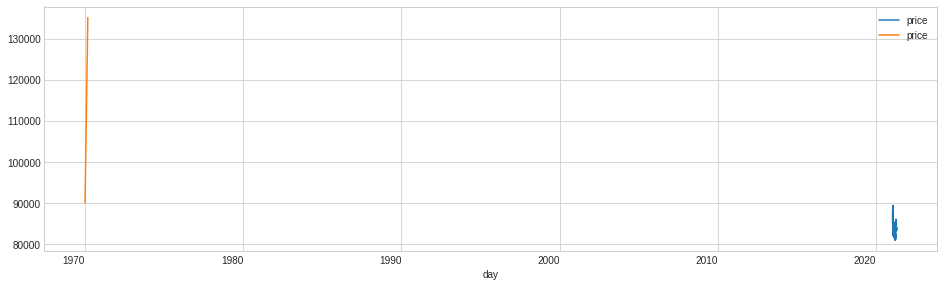

In [110]:
test_data['price'].plot(figsize = (16,5), legend=True)
pred['price'].plot(legend = True);

In [85]:
pred_ub = pred[2][:, 0]
pred_lb = pred[2][:, 1]

IndexError: invalid index to scalar variable.

In [67]:

pred_val = pred[0]
pred_ub = pred[2][:, 0]
pred_lb = pred[2][:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['price'].values, pred_val)
fig, ax = plt.subplots(figsize=(12, 6))
samsung_df['price'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

IndexError: invalid index to scalar variable.